In [58]:
from pathlib import Path
import pandas as pd

path = r"E:\AI Projects\Review Analysis\reviews"  # path

# Get the files from the path provided above
files = Path(path).glob('*.csv')  # .rglob to get subdirectories

In [86]:
dfs = list()
for f in files:
    data = pd.read_csv(f)
    #Dropping unnecessary columns
    data.drop(['Unnamed: 0','reviewId','userName','userImage','reviewCreatedVersion','replyContent','repliedAt','appVersion']\
               , axis=1, inplace=True)

    # .stem is method for pathlib objects to get the filename w/o the extension
    data['app_id'] = f.stem
    dfs.append(data)
    #only receiving data for one app
    break

reviews = pd.concat(dfs, ignore_index=True)

In [87]:
reviews.head(3)

,content,score,thumbsUpCount,at,app_id
0,Awesome app for construction.,4,0,2023-11-10 08:56:50,all.in.one.calculator
1,Great app! Best calculator that I have ever us...,5,0,2023-11-10 07:55:59,all.in.one.calculator
2,Sooooo.... Functional.,5,0,2023-11-10 04:43:43,all.in.one.calculator


In [88]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk import pos_tag, RegexpParser
import string

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Custom list of stop words
custom_stop_words = set([
    'app', 'apps', 'application', 'calculator', 'use','calculation','used', 'calculate','good','nice'  # Add more as needed
])

# Add custom and NLTK stop words
stop_words = set(stopwords.words('english')).union(custom_stop_words)

def preprocess_text(text):
    # Lowercasing
    text = text.lower()

    # Removing punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]

    # Stemming (optional)
    porter = PorterStemmer()
    stemmed_words = [porter.stem(word) for word in filtered_words]

    return ' '.join(stemmed_words)

def extract_noun_phrases(text):
    # Lowercasing
    text = text.lower()

    # Removing punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    words = word_tokenize(text)
    words = [phrase for phrase in words if phrase.lower() not in stop_words]
    
    if len(words)==0:
        return ""

    tagged_words = pos_tag(words)
    
    # Define a chunk grammar to extract noun phrases
    grammar = r"""
        NP: {<DT>?<JJ>*<NN>}   # Chunk sequences of DT, JJ, NN
            {<NNP>+}           # Chunk consecutive proper nouns
    """
    
    chunk_parser = RegexpParser(grammar)
    chunks = chunk_parser.parse(tagged_words)
    
    # Extract noun phrases
    noun_phrases = [' '.join([word for word, tag in chunk.leaves()]) for chunk in chunks if isinstance(chunk, nltk.tree.Tree)]
    
    # Filter out stop words
    filtered_noun_phrases = [phrase for phrase in noun_phrases if phrase.lower() not in stop_words]

    # Stemming
    porter = PorterStemmer()
    stemmed_words = [porter.stem(word) for word in filtered_noun_phrases]
    
    return " ".join(stemmed_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Anuj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Anuj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Anuj\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [89]:
#process text
reviews['processed_text'] = reviews['content'].astype('str').apply(preprocess_text)
# Extract noun phrases from reviews
reviews['noun_phrases'] = reviews['content'].astype('str').apply(extract_noun_phrases)

In [90]:
positive_reviews = reviews[reviews['score']>=4]
negative_reviews = reviews[reviews['score']==1]

In [91]:
from gensim import corpora, models

def apply_lda(reviews):
    tokenized_reviews = reviews
    dictionary = corpora.Dictionary(tokenized_reviews)
    corpus = [dictionary.doc2bow(review) for review in tokenized_reviews]

    lda_model = models.LdaModel(corpus, num_topics=10, id2word=dictionary, passes=30)
    
    return lda_model

positive_lda_model = apply_lda(positive_reviews['noun_phrases'].str.split())
negative_lda_model = apply_lda(negative_reviews['noun_phrases'].str.split())


In [92]:
def print_topics(lda_model):
    for topic_id, topic in lda_model.print_topics():
        print(f'Topic {topic_id + 1}: {topic}\n')

print('Positive Review Topics:')
print_topics(positive_lda_model)

print('Negative Review Topics:')
print_topics(negative_lda_model)


Positive Review Topics:
Topic 1: 0.044*"help" + 0.029*"lot" + 0.019*"wow" + 0.018*"day" + 0.017*"every" + 0.012*"simpl" + 0.012*"th" + 0.009*"important" + 0.008*"volum" + 0.007*"area"

Topic 2: 0.083*"everyth" + 0.067*"great" + 0.045*"love" + 0.035*"need" + 0.026*"work" + 0.015*"job" + 0.013*"thank" + 0.011*"download" + 0.010*"place" + 0.010*"ok"

Topic 3: 0.032*"easy" + 0.024*"convert" + 0.023*"awesom" + 0.021*"time" + 0.018*"unit" + 0.017*"anyth" + 0.015*"currenc" + 0.014*"super" + 0.014*"featur" + 0.014*"convers"

Topic 4: 0.040*"useful" + 0.030*"perfect" + 0.026*"👍" + 0.023*"math" + 0.020*"im" + 0.018*"convers" + 0.015*"excellent" + 0.013*"pleas" + 0.012*"simple" + 0.011*"dont"

Topic 5: 0.057*"excel" + 0.017*"cool" + 0.011*"play" + 0.010*"easi" + 0.009*"store" + 0.009*"conveni" + 0.008*"school" + 0.008*"top" + 0.008*"calc" + 0.008*"chang"

Negative Review Topics:
Topic 1: 0.029*"ad" + 0.024*"lot" + 0.018*"convert" + 0.018*"instal" + 0.012*"thing" + 0.012*"opt" + 0.012*"wish" + 0.0

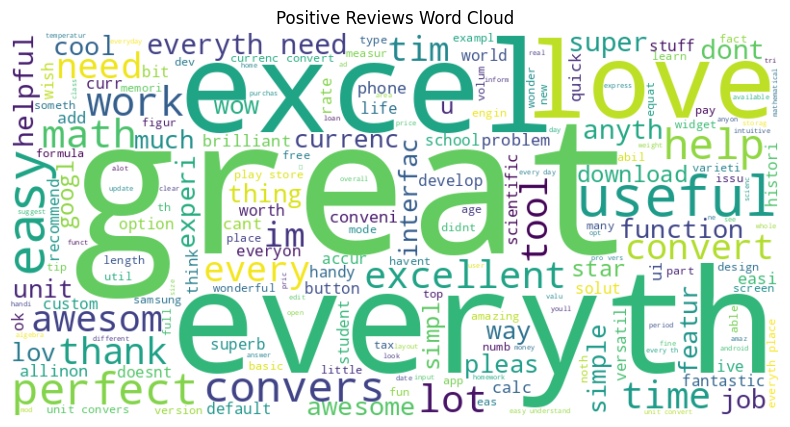

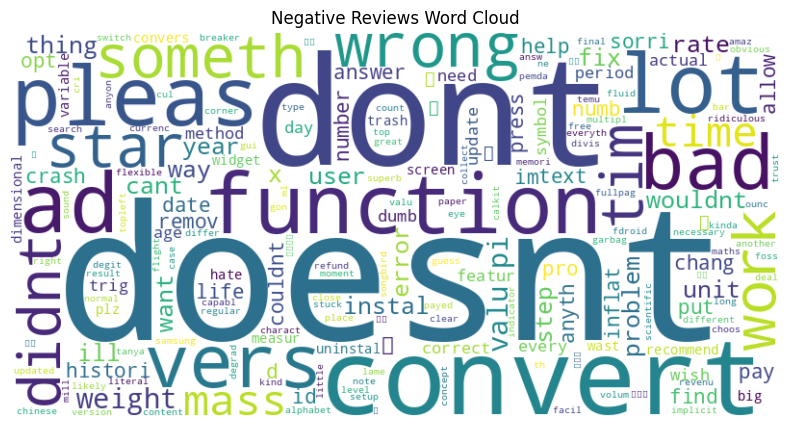

In [93]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_wordcloud(reviews, title):
    text = ' '.join(reviews)
    
    # Generate a word cloud image
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    # Display the generated image:
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Generate word clouds for positive and negative reviews
generate_wordcloud(positive_reviews['noun_phrases'], 'Positive Reviews Word Cloud')
generate_wordcloud(negative_reviews['noun_phrases'], 'Negative Reviews Word Cloud')
